# K-Nearest Neighbors

The K-Nearest Neighbors (KNN) is one of the simplest machine learning algorithms that can be used for both regression and classification. KNN is a lazy learning algorithm and doesn’t technically train a model to make predictions. Instead an observation is predicted to be the class of that of the largest proportion of the k nearest observations. KNN method is a direct attempt at approximating the conditional expectation using actual data.

For **regression**, the predicted value is the mean of the $K$ neighbors and the estimator is given as 

$$\hat{f}(x) = Average[y_i|x_i \in \mathcal{N}_k(x)]$$

where, $\mathcal{N}_k(x)$ is a neighborhood of $x$ containing the $k$ closest observations.

For **classification**, the predicted label is the class with the plurality, i.e., which class is most represented among the neighbors. This is equivlent to taking a majority vote among the $k$ nearest neighbors. For each class $j=1,...,K$, we then compute the empirical (conditional) probability 

$$P
r(G=j| X=x_0)=\frac{1}{k}\sum_{i\in \mathcal{N}_k(x)} I(y_i=j)$$

and assign the observation to the class with the highest empirical probability. Here, $I(y_i=j)$ is the indicator function returning 1 if $y_i=j$ and 0 otherwise.

## The Three Steps

The popularity of KNN comes from the fact that it is very easy to understand and interpret. It’s accuracy is often comparable or even better than more complicated algorithms. Once, $k$
 is specified, finding nearest neighbors is a 3-step process.

| Steps  | Remarks                                                      |
| ------ | ------------------------------------------------------------ |
| Step 1 | Compute the distance, usually Euclidian                      |
| Step 2 | Sort by ascending distance to find the kk NN                 |
| Step 3 | Compute the average or probability of the kk NN observations |

## Finding the Neighbours

Intuitively, distance can be thought of as a measure of similarity. Euclidean distance is the most commonly used but other distance metrics such as Manhattan work as well. The generalized distance metric is called the Minkowski distance, defined as 

$$d = \bigg( \sum_{n=i}^n |x_i-y_i|^p \bigg)^{1/p}$$

, where $x_i$ and $y_i$ are the two observations for which distance $d$ is being calculated with a hyperparameter, integer $p$.

When $p=1$, the distance is the **Manhattan distance** and when $p=2$, the distance is the just the standard **Euclidean distance**. With the $K$ neighbors identified using distance metrics, the algorithm can make a classification or prediction with the label values of the neighbors.

# KNN Model

KNN is a non-parametric method and it does not assume any function as there are no parameters to be estimated. The selection of the number of neighbors $k$ is done using the training set. Selecting $k$ close to 1 gives the most flexibility (low bias), but also has the highest variability (high variance) while on the other hand, selecting a large $k$ gives the least flexibility (high bias), but also has the lowest variability (low variance). In particular, $k=N$ will assign all new test observations to a single class. 

The best way of selecting $k$ is through cross validation. Another alternative approach is to employ the popular Elbow method to select $k$.

## Problem Statement

The objective is to predict market movement based on classification algorithm. In this lab, we'll use KNN to predict market direction and devise a trading strategies based on it.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

# processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (train_test_split,
                                     GridSearchCV, 
                                     TimeSeriesSplit, 
                                     cross_val_score)

# Classifier
from sklearn.neighbors import KNeighborsClassifier

# Metrics
from sklearn.metrics import (precision_recall_curve, 
                             roc_curve, 
                             RocCurveDisplay, 
                             ConfusionMatrixDisplay)

from sklearn.metrics import (accuracy_score, 
                             f1_score, 
                             recall_score, 
                             precision_score, 
                             roc_auc_score, 
                             auc)

from sklearn.metrics import (classification_report, 
                             confusion_matrix)

import warnings
warnings.filterwarnings('ignore')


# https://towardsdatascience.com/20-simple-yet-powerful-features-for-time-series-using-date-and-time-af9da649e5dc

## Load Data

In [2]:
# Load locally stored data
df = pd.read_csv('spy.csv', index_col=0, parse_dates=True)

# Check first 5 values 
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-12-31,146.84375,147.50000,146.250000,146.8750,100.376900,3172700
2000-01-03,148.25000,148.25000,143.875000,145.4375,99.394493,8164300
2000-01-04,143.53125,144.06250,139.640625,139.7500,95.507530,8089800
2000-01-05,139.93750,141.53125,137.250000,140.0000,95.678391,12177900
2000-01-06,139.62500,141.50000,137.750000,137.7500,94.140717,6227200


## EDA of Original dataset

(EDA stands for Explantory Data Analysis)

In [3]:
# Descriptive statistics
df.describe()


,Open,High,Low,Close,Adj Close,Volume
count,5114.000000,5114.000000,5114.000000,5114.000000,5114.000000,5.114000e+03
mean,159.857972,160.798386,158.829985,159.860942,136.333938,1.127593e+08
std,60.679463,60.830274,60.515930,60.694065,67.923663,9.870486e+07
min,67.949997,70.000000,67.099998,68.110001,54.184429,1.436600e+06
25%,115.752501,116.662502,114.902502,115.897499,87.412493,4.821255e+07
50%,137.085007,137.955002,136.110001,136.945000,106.488850,8.357545e+07
75%,201.767498,202.787498,200.722504,201.872505,182.951584,1.515544e+08
max,337.790009,339.079987,337.480011,338.339996,336.362091,8.710263e+08


## Cleaning & Imputation

Data is already cleaned. No further processing or imputation required.

In [4]:
# Check for missing values
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## Feature Specification

Features or Predictors are also known as an independent variable which are used to determine the value of the target variable. We will derive a features set from the original dataset.

In [5]:
# Predictors
df['O-C'] = df.Open - df.Close
df['H-L'] = df.High - df.Low

X = df[['O-C', 'H-L']].values

## Target or Label Definition

Label or the target variable is also known as the dependent variable. Here, the target variable is whether Nifty Index price will close up or down on the next trading day. If the tomorrow’s closing price is greater than the 0.995 of today's closing price, then we will buy the Nifty, else we will sell the index.

We assign a value of +1 for the buy signal and -1 for the sell signal to target variable. The target can be described as : 

$$y_t = \begin{cases}  +1, & \text{if}\ \ p_{t+1}> 0.995 \times p_t \\
-1,& \text{if}\ \ p_{t+1} \ \text{otherwise} \end{cases}$$

where, $p_t$ is the current closing price of Nifty Index and $p_{t+1}$ is the 1-day forward closing price of the index.

In [6]:
# Target
y = np.where(df['Adj Close'].shift(-1)>0.995*df['Adj Close'],1,-1) 
y

array([-1, -1,  1, ...,  1,  1, -1])

In [7]:
# Value counts for class 1 and -1
pd.Series(y).value_counts()

 1    3885
-1    1229
dtype: int64

## Split Data

In [8]:
# Splitting the datasets into training and testing data.
# Always keep shuffle = False for financial time series
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Output the train and test data size
print(f"Train and Test Size {len(X_train)}, {len(X_test)}")

Train and Test Size 4091, 1023


## Fit Model

Since the KNN model calculates distances, the dataset needs to be scaled for the model to work properly. All the features should have a similar scale. The scaling can be accomplished by using the `MinMaxScaler` transformer.

In [37]:
# Scale and fit the model
model = Pipeline([
    ("scaler", MinMaxScaler()), 
    ("classifier", KNeighborsClassifier())
]) 
model.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('classifier', KNeighborsClassifier())])

## Predict Model

In [39]:
# Predicting the test dataset
y_pred = model.predict(X_test)

# Predict Probabilities
y_proba = model.predict_proba(X_test)

In [42]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)

print(f'Train Accuracy: {acc_train:0.4}, Test Accuracy: {acc_test:0.4}')

Train Accuracy: 0.7802, Test Accuracy: 0.7498


# Prediction Quality

## Confusion Matrix

Confusion matrix is a table used to describe the performance of a classification model on a set of test data for which the true values are known.


| Outcome        | Position |
| -------------- | ----------------- |
| True Negative  | upper-left        |
| False Negative | lower-left        |
| False Positive | upper-right       |
| True Positive  | lower-right       |


**True Positive** is an outcome where the model correctly predicts the positive class. Similarly, a true negative is an outcome where the model correctly predicts the negative class.

**False Positive** is an outcome where the model incorrectly predicts the positive class. And a false negative is an outcome where the model incorrectly predicts the negative class.

Note: In a binary classification task, the terms ‘positive’ and ‘negative’ refer to the classifier’s prediction, and the terms ‘true’ and ‘false’ refer to whether that prediction corresponds to the external judgment (sometimes known as the ‘observation’) and the axes can be flipped.

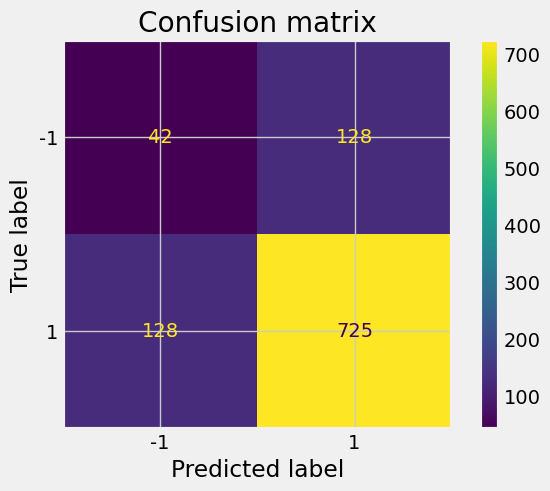

In [53]:
# Display confussion matrix
disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=model.classes_
    )
disp.ax_.set_title('Confusion matrix')
plt.show()

## Classification Report

A classification report is used to measure the quality of predictions from a classification algorithm.

In [13]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.25      0.25      0.25       170
           1       0.85      0.85      0.85       853

    accuracy                           0.75      1023
   macro avg       0.55      0.55      0.55      1023
weighted avg       0.75      0.75      0.75      1023



**Macro Average**

Average of precision (or recall or f1-score) of different classes.

**Weighted Average**

Actual Class1 instance * precision (or recall or f1-score) of Class1 + Actual Class2 instance * (or recall or f1-score) of Class2.

## Receiver Operator Characterisitc Curve (ROC)

The area under the ROC curve (AUC) is a measure of how well a model can distinguish between two classes. The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various classification thresholds.

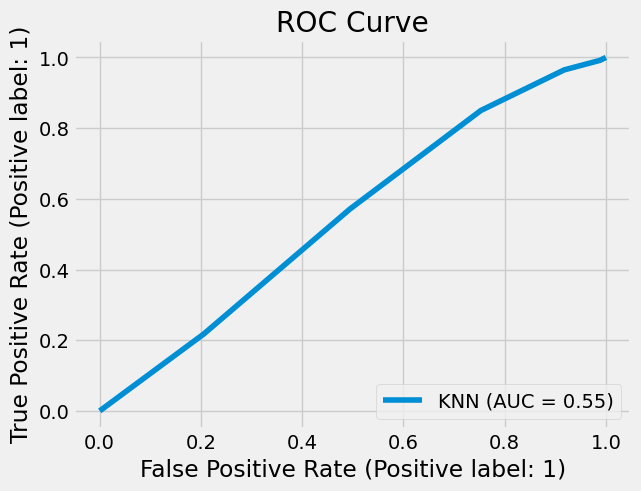

In [14]:
# Display ROCCurve 
disp_roc = RocCurveDisplay.from_estimator(
            model, 
            X_test, 
            y_test,
            name='KNN')
disp_roc.ax_.set_title('ROC Curve')
plt.show()

# Hyper-parameter Tuning (调参)
Hyper-parameters are parameters that are not directly learnt within estimators. In scikit-learn they are passed as arguments to the constructor of the estimator classes. It is possible and recommended to search the hyper-parameter space for the best cross validation score. Any parameter provided when constructing an estimator may be optimized in this manner.

Cross-validation of Time Series

**Time series data are sequential in nature and are characterised by the correlation between observations. Classical cross-validation techniques such as K-fold assumes the samples are independent and identically distributed, and would result in poor estimates when applied on time series data.**

To preserve the order and have training set occur prior to the test set, we use Forward Chaining method in which the model is initially trained and tested with the same windows size. And, for each subsequent fold, the training window increases in size, encompassing both the previous training data and test data. The new test window once again follows the training window but stays the same length.

https://i.stack.imgur.com/gzsVX.png![image.png](attachment:image.png)

The figure shows the time-series split for cross validation.

We will tune the hyperparameters to select the K-Best Neighbor by TimeSeriesSplit from scikit-learn. This is a forward chaining cross-validation method and is a variation from the K-fold. In the $k^{th}$ split, it returns first k folds as train set and the (k+1)th fold as test set. Unlike standard cross-validation methods, successive training sets are supersets of those that come before them.

In [70]:
# Example: First 2 split
tscv = TimeSeriesSplit(n_splits=2, gap=1)
for train, test in tscv.split(X):
    print(train, test)

[   0    1    2 ... 1702 1703 1704] [1706 1707 1708 ... 3407 3408 3409]
[   0    1    2 ... 3406 3407 3408] [3410 3411 3412 ... 5111 5112 5113]


In [71]:
# Cross-validation
tscv = TimeSeriesSplit(n_splits=5, gap=1)

## GridSearch

The conventional way of performing hyperparameter optimisation has been a grid search (aka parameter sweep). It is an exhaustive search through a manually specified subset of the hyperparameter space of a learning algorithm. A grid search algorithm must be guided by some performance metric, typically measured by cross-validation on the training set or evaluation on a validation set.

GridSearch performs exhaustive search over specified parameter values for an estimator. It implements a “fit” and a “score” method among other methods. The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid.

In [72]:
# Get parameters list
model.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler()), ('classifier', KNeighborsClassifier())],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'classifier': KNeighborsClassifier(),
 'scaler__clip': False,
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'classifier__algorithm': 'auto',
 'classifier__leaf_size': 30,
 'classifier__metric': 'minkowski',
 'classifier__metric_params': None,
 'classifier__n_jobs': None,
 'classifier__n_neighbors': 5,
 'classifier__p': 2,
 'classifier__weights': 'uniform'}

In [74]:
%%time
# Perform Gridsearch and fit
param_grid = {"classifier__n_neighbors": np.arange(1,51,1)}

grid_search = GridSearchCV(model, param_grid, scoring='roc_auc', n_jobs=-1, cv=tscv, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
CPU times: user 89.6 ms, sys: 12.2 ms, total: 102 ms
Wall time: 206 ms


GridSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('classifier', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])},
             scoring='roc_auc', verbose=1)

In [75]:
# Best Params & Scores
print(f"Optimal Neighbours: {grid_search.best_params_['classifier__n_neighbors']}, Best Scors: {round(grid_search.best_score_,4)}")

Optimal Neighbours: 18, Best Scors: 0.5361


## Tuned Model

Let's now train and predict the model with the best search parameter.

In [76]:
# Instantiate KNN model with search param
clf = KNeighborsClassifier(n_neighbors = grid_search.best_params_['classifier__n_neighbors'])
# Fit the model
clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=18)

In [77]:
# Predicting the test dataset
y_pred = clf.predict(X_test)
# Measure Accuracy
acc_train = accuracy_score(y_train, clf.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)
# Print Accuracy
print(f'\n Training Accuracy \t: {acc_train :0.4} \n Test Accuracy \t\t: {acc_test :0.4}')


 Training Accuracy 	: 0.747 
 Test Accuracy 		: 0.7859


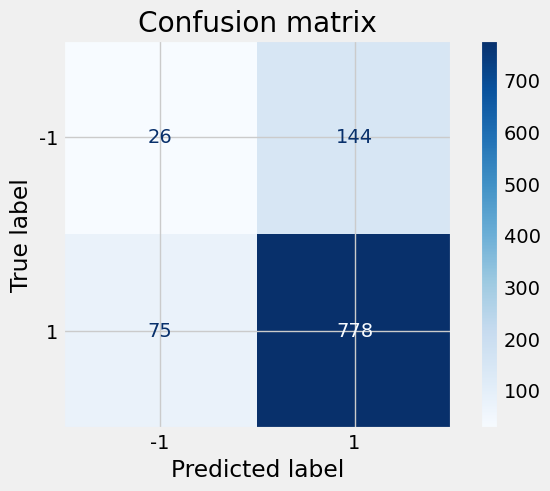

In [78]:
# Display confussion matrix
disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        display_labels=model.classes_,
        cmap=plt.cm.Blues
    )
disp.ax_.set_title('Confusion matrix')
plt.show()

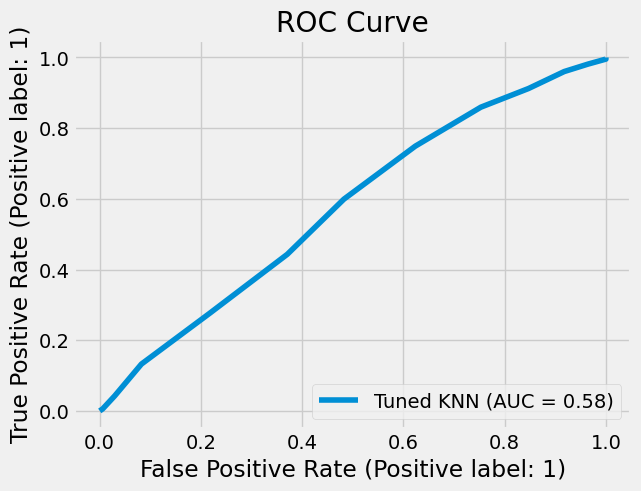

In [79]:
# Display ROCCurve 
disp_roc = RocCurveDisplay.from_estimator(
            clf, 
            X_test, 
            y_test,
            name='Tuned KNN')
disp_roc.ax_.set_title('ROC Curve')
plt.show()

In [80]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.26      0.15      0.19       170
           1       0.84      0.91      0.88       853

    accuracy                           0.79      1023
   macro avg       0.55      0.53      0.53      1023
weighted avg       0.75      0.79      0.76      1023



**Observation**

1. Test accuracy improved more than 5% as compared to the earlier model.
2. Recall for Class +1 improved by more than 10% as compared to the earlier model while recall for Class -1 decreased by 40%.
3. Model improved predictor for upside when compared to the downside.
4. Class imbalance skews the prediction and needs to be addressed.


# Trading Strategy

Let's now define a trading strategy. We will use the predicted signal to buy or sell. We then compare the result of this strategy with the buy and hold and visualize the performance of the KNN Algorithm.

In [81]:
# Subsume into a new dataframe
df1 = df.copy()                      # df[-len(X_test)
df1['Signal'] = clf.predict(X)       # clf.predict(X_test)

In [82]:
# Daily Returns
df1['Returns'] = np.log(df1['Adj Close']).diff().fillna(0)

# Strategy Returns
df1['Strategy'] = df1['Returns'] * df1['Signal'].shift(1).fillna(0)

# Localize index for pyfolio
df1.index = df1.index.tz_localize('utc')

In [83]:
# Check the output
df1.tail(10)

,Open,High,Low,Close,Adj Close,Volume,O-C,H-L,Signal,Returns,Strategy
Date,,,,,,,,,,,
2020-04-16 00:00:00+00:00,279.149994,280.029999,275.760010,279.100006,279.100006,131798300,0.049988,4.269989,1,0.004813,0.004813
2020-04-17 00:00:00+00:00,285.380005,287.299988,282.399994,286.640015,286.640015,146684800,-1.260010,4.899994,1,0.026657,0.026657
2020-04-20 00:00:00+00:00,282.609985,286.790009,281.350006,281.589996,281.589996,100109300,1.019989,5.440002,1,-0.017775,-0.017775
2020-04-21 00:00:00+00:00,276.730011,278.040009,272.019989,273.040009,273.040009,126385700,3.690002,6.020020,1,-0.030834,-0.030834
2020-04-22 00:00:00+00:00,278.350006,281.000000,276.910004,279.100006,279.100006,93524600,-0.750000,4.089996,-1,0.021952,0.021952
2020-04-23 00:00:00+00:00,280.489990,283.940002,278.750000,279.079987,279.079987,104709700,1.410004,5.190002,1,-0.000072,0.000072
2020-04-24 00:00:00+00:00,280.730011,283.700012,278.500000,282.970001,282.970001,85166000,-2.239990,5.200012,1,0.013842,0.013842
2020-04-27 00:00:00+00:00,285.119995,288.269989,284.619995,287.049988,287.049988,77896600,-1.929993,3.649994,-1,0.014315,0.014315
2020-04-28 00:00:00+00:00,291.019989,291.399994,285.399994,285.730011,285.730011,105270000,5.289978,6.000000,1,-0.004609,0.004609


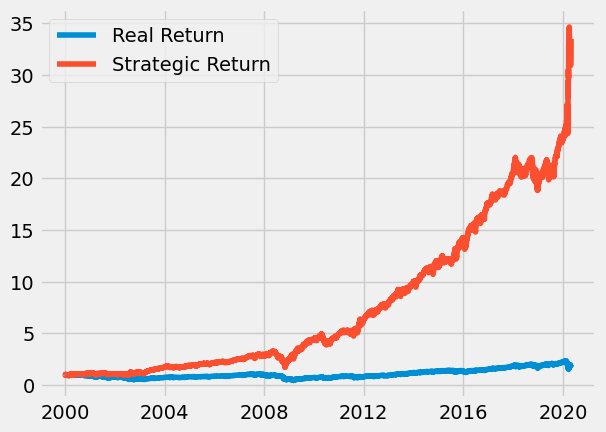

In [88]:
plt.plot((df1.Returns+1).cumprod(), label='Real Return')
plt.plot((df1.Strategy+1).cumprod(), label='Strategic Return')
plt.legend()
plt.show()

# Return Analysis

In [30]:
# Import pyfolio
import pyfolio as pf

Start date,1999-12-31
End date,2020-04-29
Total months,243
,Backtest
Annual return,18.9%
Cumulative returns,3247.5%
Annual volatility,19.9%
Sharpe ratio,0.97
Calmar ratio,0.39
Stability,0.99
Max drawdown,-47.9%


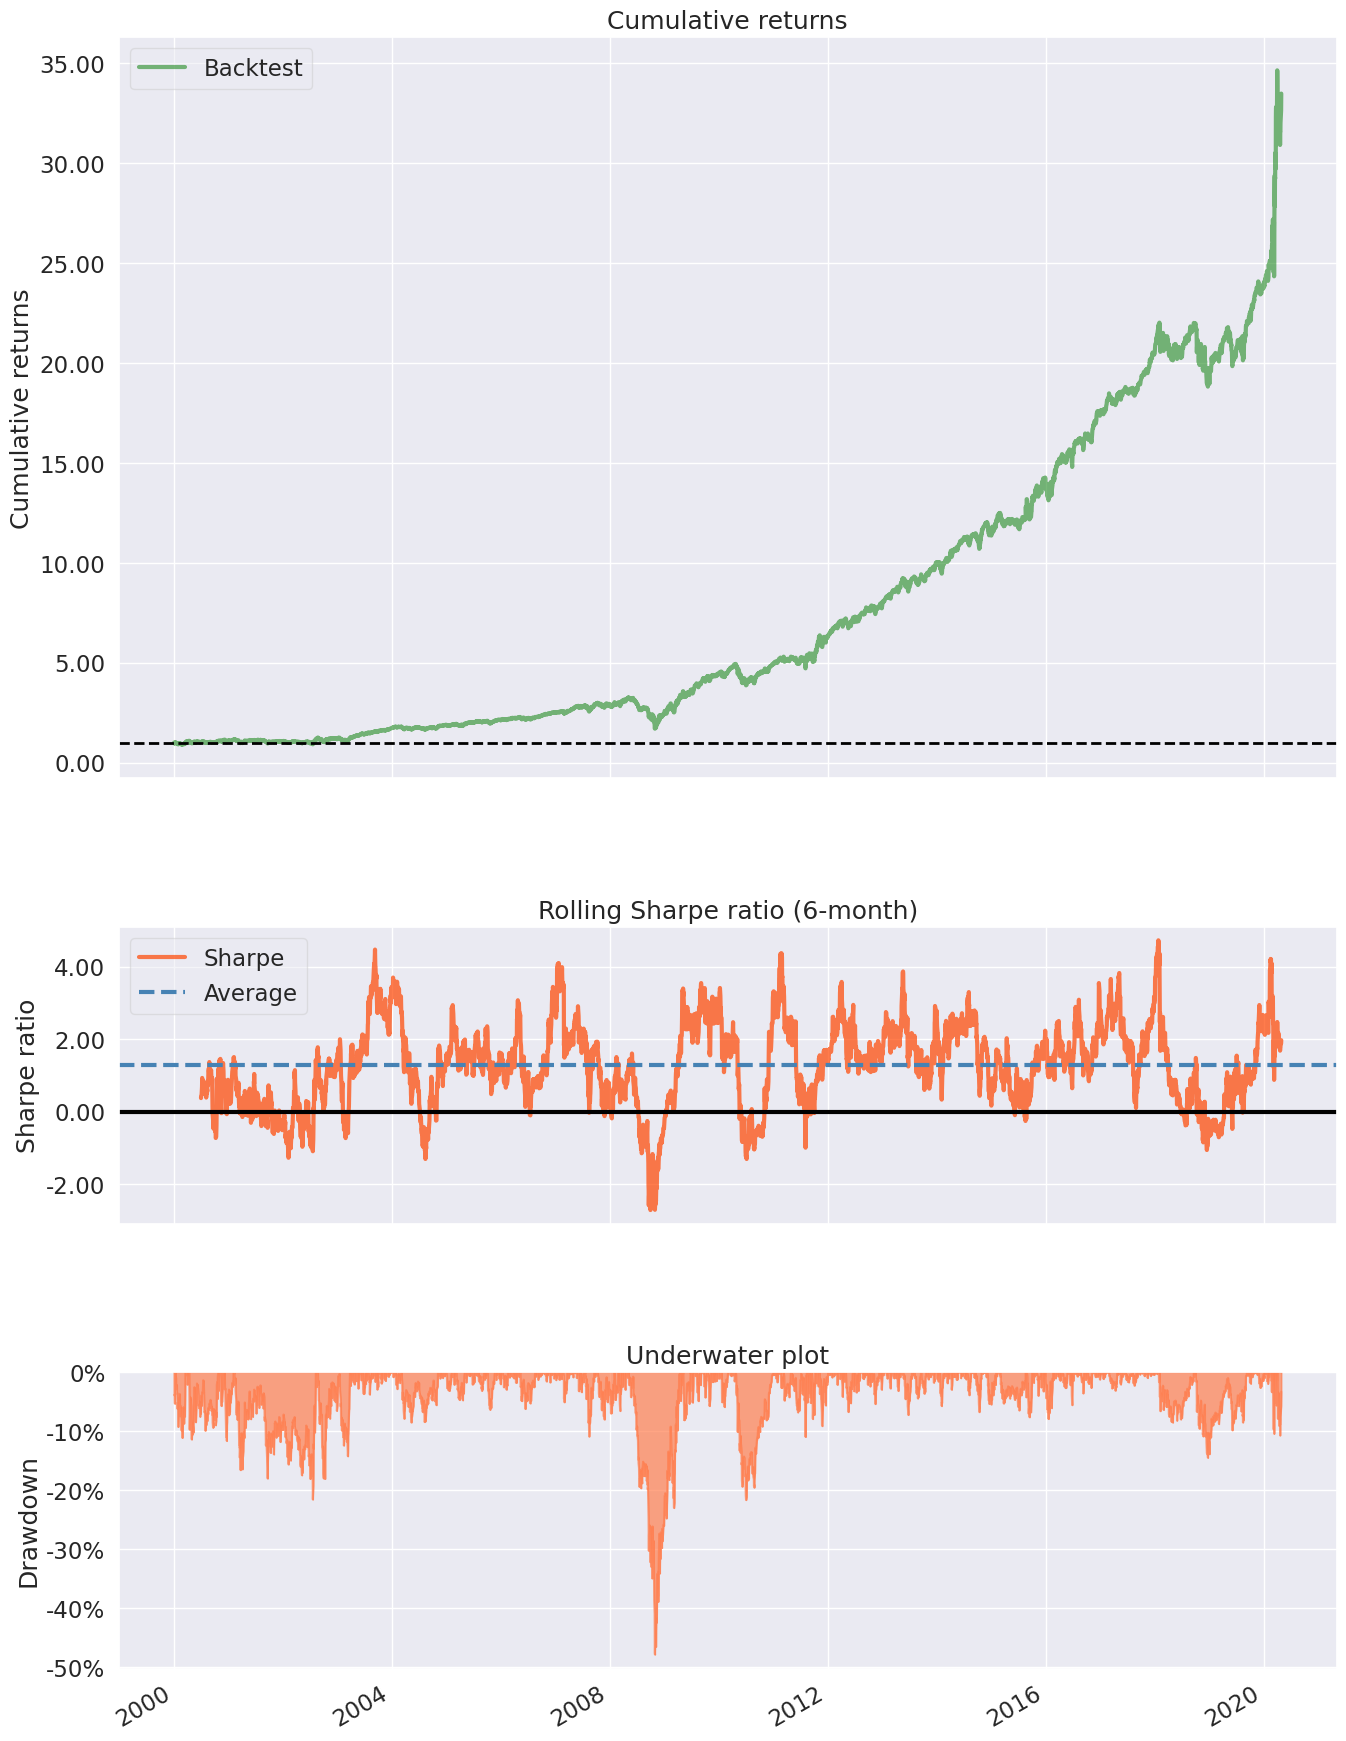

In [89]:
# Create Tear sheet using pyfolio for outsample - for X_test
pf.create_simple_tear_sheet(df1['Strategy'])

In [90]:
# Live start date 2016-04-07
pf.create_returns_tear_sheet(df1['Strategy'], live_start_date='2016-04-07')

AttributeError: 'numpy.int64' object has no attribute 'to_pydatetime'